In [1]:
#%matplotlib inline
#!pip install pennylane
#!pip install qulacs pennylane-qulacs
#!pip install seaborn
#!pip install lightning
#!pip install ipynbname

In [2]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm
import pennylane as qml
#from pennylane.utils import _flatten, unflatten
from pennylane import GradientDescentOptimizer
import copy
#from momentum_qng import MomentumQNGOptimizer 

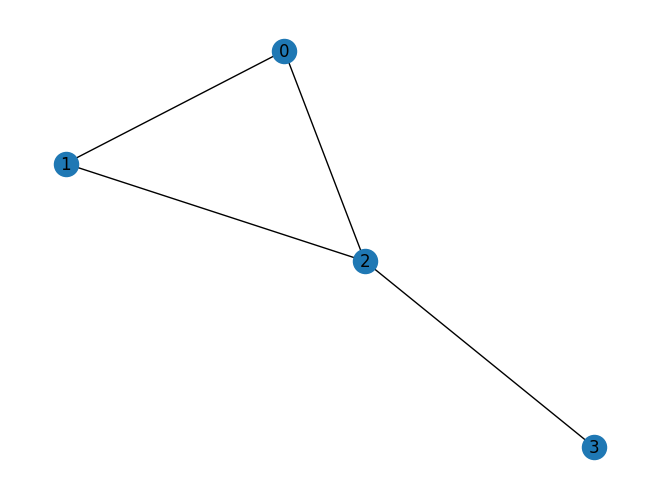

In [3]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [4]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


In [5]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [6]:
wires = range(4)
depth = 4

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [7]:
def plot_opt_data(opt_costs,opt_quality,opt_steps,opt_title,opt_color):
    fig = plt.figure(figsize=(12, 3), layout="compressed")
    axs = fig.subplots(1, 4, sharey=False)
    #fig, axs = plt.subplots(1, 4, sharey=False, tight_layout=False)
    
    # We can set the number of bins with the *bins* keyword argument.
    n_bins = 10
    quality_bins = [i*0.02 for i in range(50)]
    cost_bins = [-3+i*0.04 for i in range(75)]
    steps_bins = [i for i in range(steps+1)]
    axs[0].hist(opt_costs, bins=cost_bins,color=opt_color)
    axs[1].hist(opt_quality, bins=quality_bins,color=opt_color)
    axs[2].scatter(opt_costs,opt_quality,color=opt_color)
    axs[3].hist(opt_steps, bins=steps_bins,color=opt_color)
    axs[0].set_xlabel("optimized cost")
    axs[0].set_ylabel("count")
    axs[1].set_xlabel("quality ratio")
    axs[1].set_ylabel("count")
    #axs[0].set_title(opt_title)
    #axs[1].set_title(opt_title)
    axs[2].set_xlabel("optimized cost")
    axs[2].set_ylabel("quality ratio")
    axs[2].set_xlim(-3,0)
    axs[2].set_ylim(0,1)
    axs[3].set_xlabel("steps")
    axs[3].set_ylabel("count")   
    plt.suptitle(opt_title)
    plt.show()

In [8]:
def run_session(optimizer,optimizer_params,init_params_array,steps,cost_tolerance,cost_tolerance_count,device_name):
    dev = qml.device(device_name, wires=wires)
    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost_h)
    
    @qml.qnode(dev)
    def probability_circuit(gamma, alpha):
        circuit([gamma, alpha])
        return qml.probs(wires=wires)
    def quality_ratio(params):
        probs = probability_circuit(params[0], params[1])
        return probs[6]+probs[10]
    
    def asymmetry_ratio(params):
        probs = probability_circuit(params[0], params[1])
        return probs[6]/probs[10]    
    
    opt_params = []
    opt_steps = []
    opt_costs = []
    opt_quality = []
    opt_asym = []
    for init_params in tqdm(init_params_array):
        opt = copy.deepcopy(optimizer)
        for id in optimizer_params:
            setattr(opt, id, optimizer_params[id])
        params = init_params
        best_cost = 100
        cost_counter = 0
        for i in range(steps):
            params = opt.step(cost_function, params)
            cur_cost = cost_function(params)
            if(abs(best_cost - cur_cost) < cost_tolerance):
                cost_counter += 1
                if(cost_counter > cost_tolerance_count):
                    break
            else:
                cost_counter = 0
            if(best_cost > cur_cost):
                best_cost = cur_cost
        opt_params.append(params)
        opt_steps.append(i)
        opt_costs.append(cur_cost)
        opt_quality.append(quality_ratio(params))
        opt_asym.append(asymmetry_ratio(params))
    return (opt_params,opt_steps,opt_costs,opt_quality,opt_asym)

In [9]:
stepsizes = [0.01,0.025]
stepsizes += [0.05 + 0.05*(x) for x in range(80)]
sessions = [
    {"optimizer" : qml.QNGOptimizer(),
     "params" : {"approx" : 'block-diag', "lam" : 0.5},
     "params_name" : "approx='block-diag', $\mathit{"+ chr(955) + "}$=0.5",
     "stepsizes" : stepsizes,
     "dev" : "default.qubit"},
#    {"optimizer" :  qml.AdamOptimizer(),
#     "params" : {"beta1" : 0.9, "beta2" : 0.99, "epsilon" : 1.0e-8},
#     "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^{-8}$",
#     "stepsizes" : stepsizes,
#     "dev" : "default.qubit"},
#    {"optimizer" :  qml.MomentumOptimizer(),
#     "params" : {"momentum" : 0.9},
#     "params_name" : "$\mathit{"+ chr(961) +"}$=0.9",
#     "stepsizes" : [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.125],
#     "dev" : "default.qubit"},
#    {"optimizer" :  MomentumQNGOptimizer(),
#     "params" : {"momentum" : 0.9, "approx" : 'block-diag', "lam" : 0.5},
#     "params_name" : "$\mathit{"+ chr(961) +"}$=0.9, approx='block-diag', $\mathit{"+ chr(955) + "}$=0.5",
#     "stepsizes" : stepsizes,
#     "dev" : "default.qubit"}
]

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mbrat\AppData\Local\Temp\ipykernel_223404\3936887239.py:6: SyntaxWarning: invalid escape sequence '\m'
  "params_name" : "approx='block-diag', $\mathit{"+ chr(955) + "}$=0.5",


In [10]:
init_count = 200
steps = 200

cost_tolerance = 0.01
cost_tolerance_count = 3

seed_value = 34093197

init_params_array = []
np.random.seed(seed_value)
for i in range(init_count):
    gam = np.random.random(depth)
    alp = np.random.random(depth)
    init_params_array.append(np.array([gam, alp], requires_grad=True))

100%|██████████| 200/200 [54:36<00:00, 16.38s/it] 


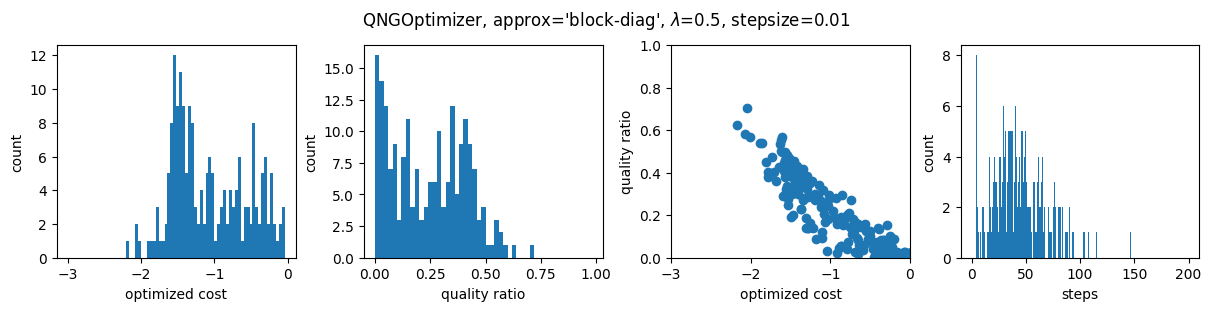

100%|██████████| 200/200 [47:59<00:00, 14.40s/it] 


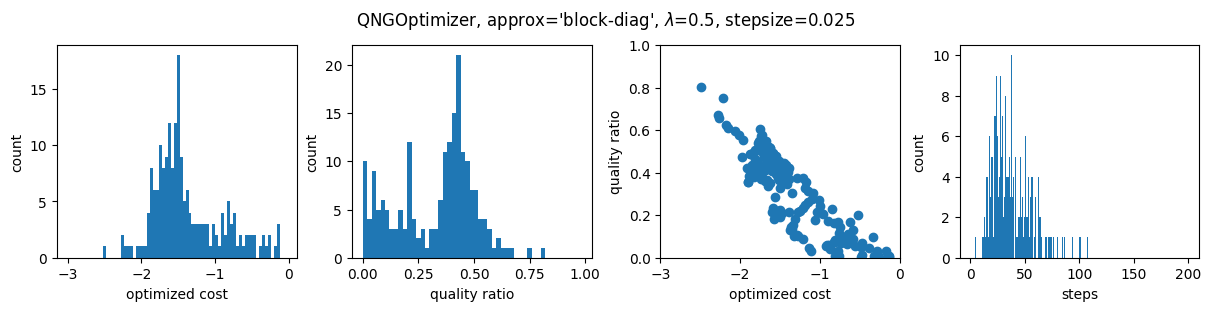

100%|██████████| 200/200 [37:10<00:00, 11.15s/it]


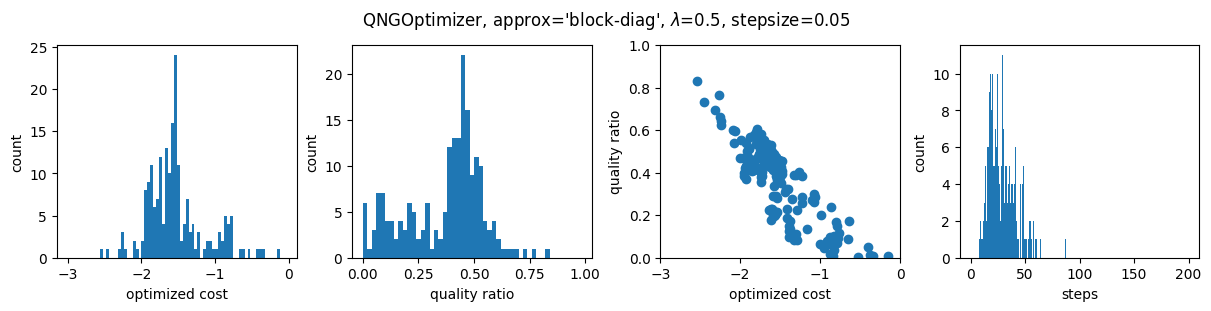

100%|██████████| 200/200 [39:14<00:00, 11.77s/it] 


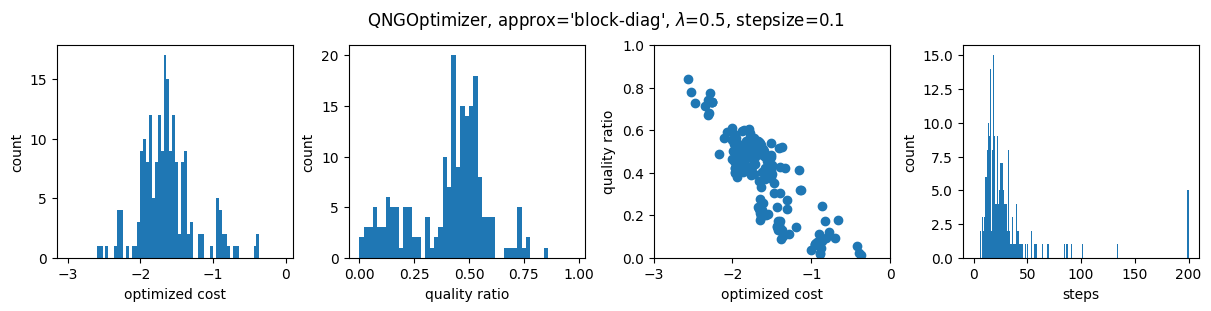

100%|██████████| 200/200 [1:45:42<00:00, 31.71s/it]  


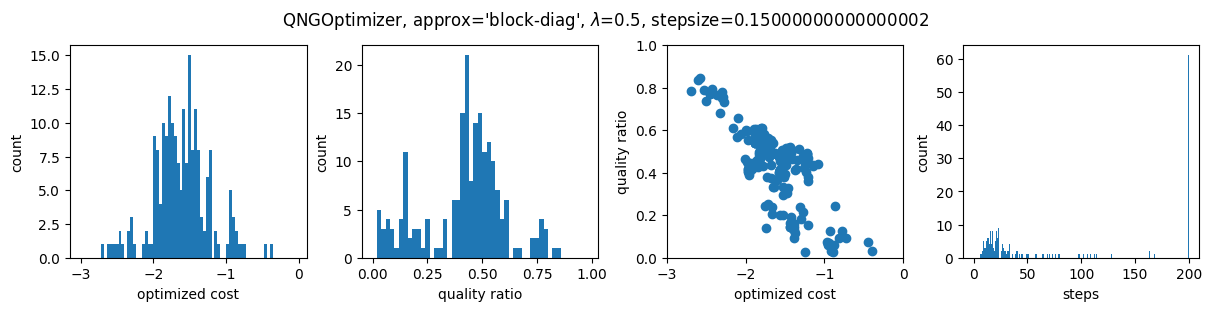

100%|██████████| 200/200 [2:43:30<00:00, 49.05s/it]  


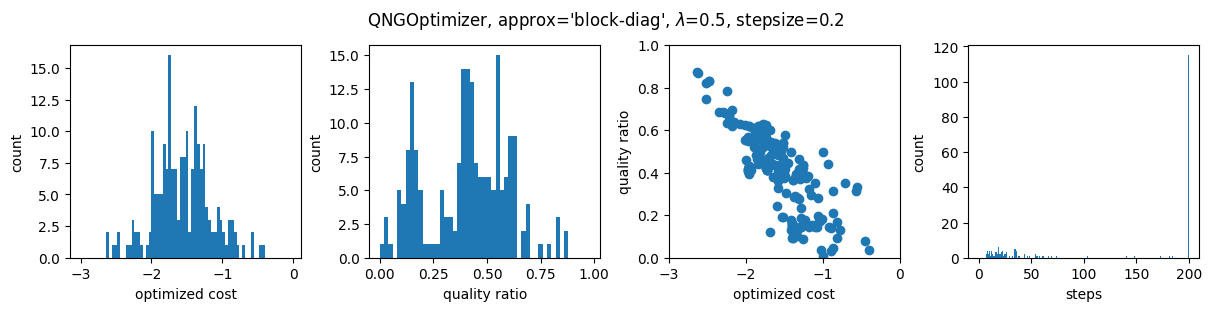

100%|██████████| 200/200 [3:34:14<00:00, 64.27s/it]  


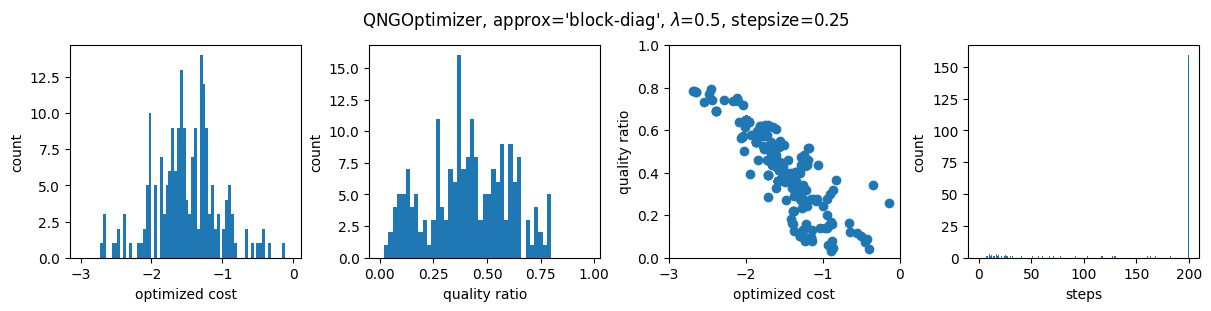

100%|██████████| 200/200 [3:24:23<00:00, 61.32s/it]  


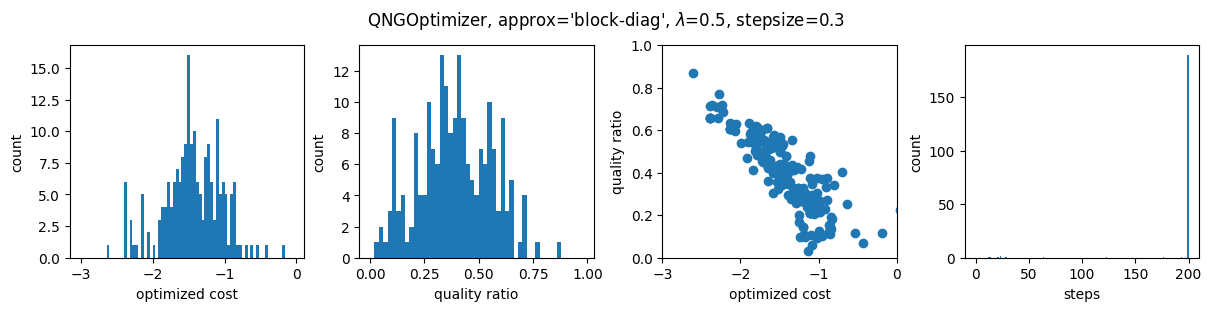

100%|██████████| 200/200 [2:54:23<00:00, 52.32s/it]  


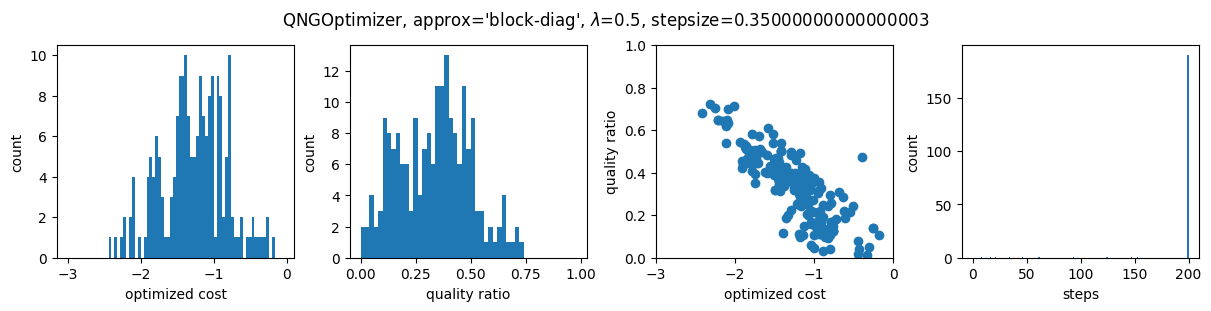

100%|██████████| 200/200 [2:53:52<00:00, 52.16s/it]  


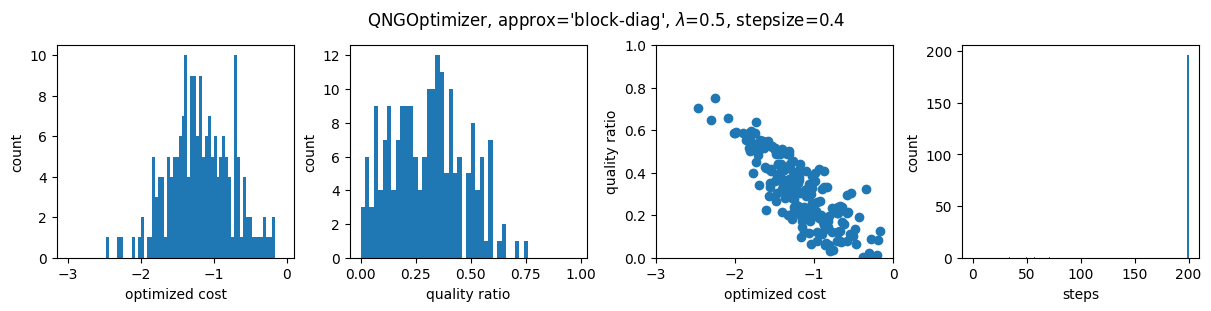

100%|██████████| 200/200 [3:09:23<00:00, 56.82s/it]  


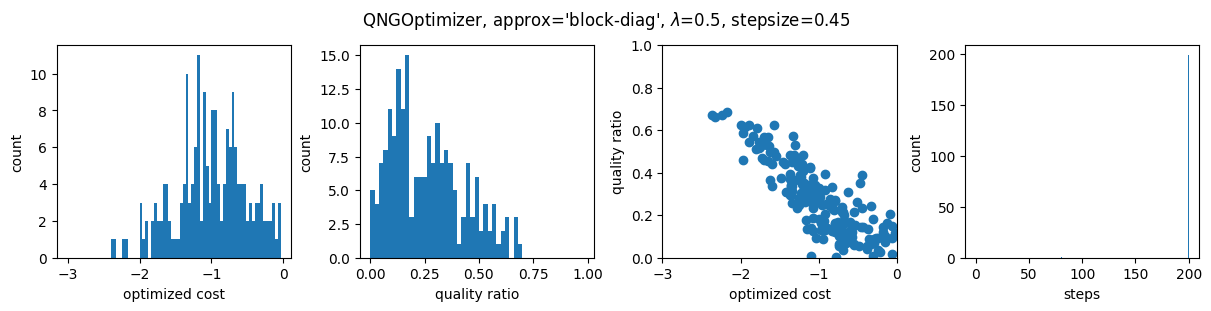

100%|██████████| 200/200 [3:16:58<00:00, 59.09s/it]  


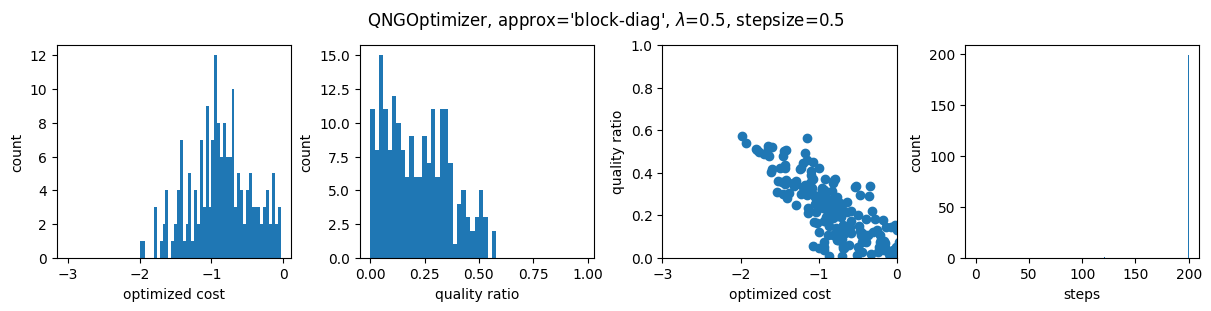

100%|██████████| 200/200 [3:18:13<00:00, 59.47s/it]  


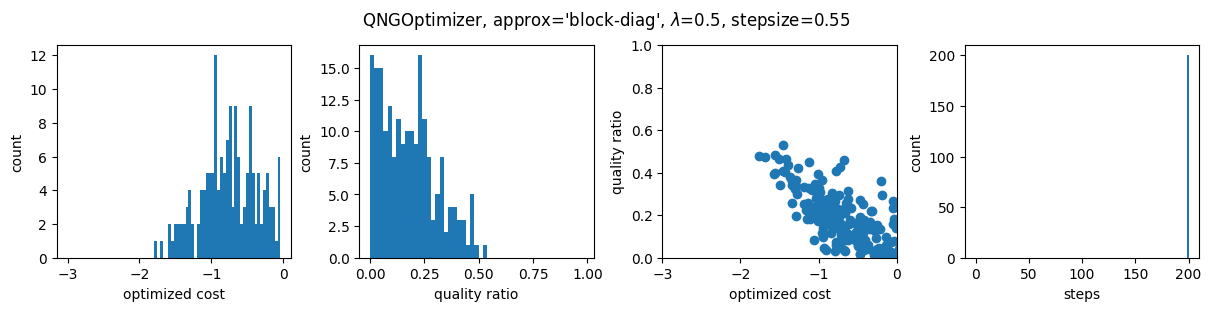

In [11]:
sessions_params = []
sessions_steps = []
sessions_costs = []
sessions_quality = []
sessions_asym = []
for i,session in enumerate(sessions):
    cur_params = []
    cur_steps = []
    cur_costs = []
    cur_quality = []
    cur_asym = []
    for stepsize in session["stepsizes"]:
        session_params = copy.deepcopy(session["params"])
        session_params["stepsize"] = stepsize
        (opt_params,opt_steps,opt_costs,opt_quality,opt_asym) = run_session(session["optimizer"],session_params,init_params_array,steps,cost_tolerance,cost_tolerance_count,session["dev"])
        title = session["optimizer"].__class__.__name__
        if(len(session["params_name"]) > 0):
            title += ", "+ session["params_name"]
        title += ", stepsize=" + str(stepsize)
        plot_opt_data(opt_costs,opt_quality,opt_steps,title,'C'+str(i))
        cur_params.append(opt_params)
        cur_steps.append(opt_steps)
        cur_costs.append(opt_costs)
        cur_quality.append(opt_quality)
        cur_asym.append(opt_asym)
        if(np.array(opt_quality).mean() < 0.2):
            break

    sessions_params.append(cur_params)
    sessions_steps.append(cur_steps)
    sessions_costs.append(cur_costs)
    sessions_quality.append(cur_quality)
    sessions_asym.append(cur_asym)

In [16]:
stepsizes = [0.01,0.025]
stepsizes += [0.05 + 0.05*(x) for x in range(11)]
sessions[0]["stepsizes"] = stepsizes


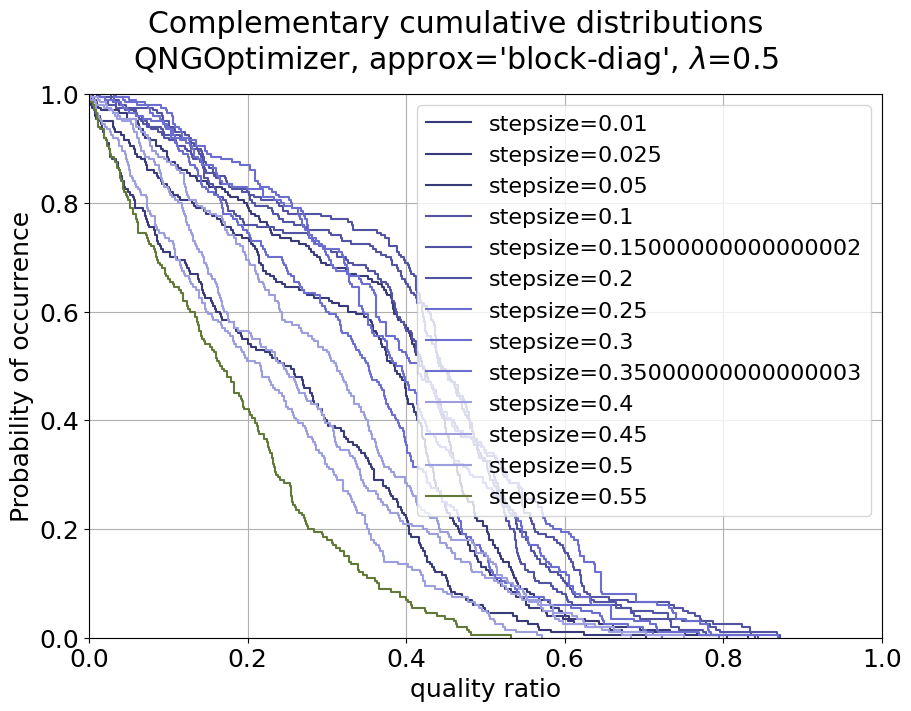

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [17]:
import matplotlib as mpl
from datetime import date
import ipynbname

mpl.rcParams['font.size'] = 18

prefix_name = ipynbname.name() + "_" + str(date.today()) + "_"

cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 60))

for i,session in enumerate(sessions):
    fig = plt.figure(figsize=(9, 7), layout="compressed")
    axs = fig.subplots(1, 1, sharex=True, sharey=True)
    
    # Cumulative distributions.
    
    for j,stepsize in enumerate(session["stepsizes"]):
        axs.ecdf(sessions_quality[i][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )
        
    # Label the figure.
    title = "Complementary cumulative distributions\n" + session["optimizer"].__class__.__name__
    if(len(session["params_name"]) > 0):
        title += ", " + session["params_name"]
    
    fig.suptitle(title)
    
    axs.grid(True)
    axs.legend(fontsize=16)
    axs.set_xlabel("quality ratio")
    axs.set_ylabel("Probability of occurrence")
    axs.label_outer()
    axs.set_xlim(0.0, 1)
    plt.show()
    fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_quality.png",format='png',dpi=300)
    fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_quality.pdf",format='pdf',dpi=300)
    fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_quality.eps",format='eps',dpi=300)

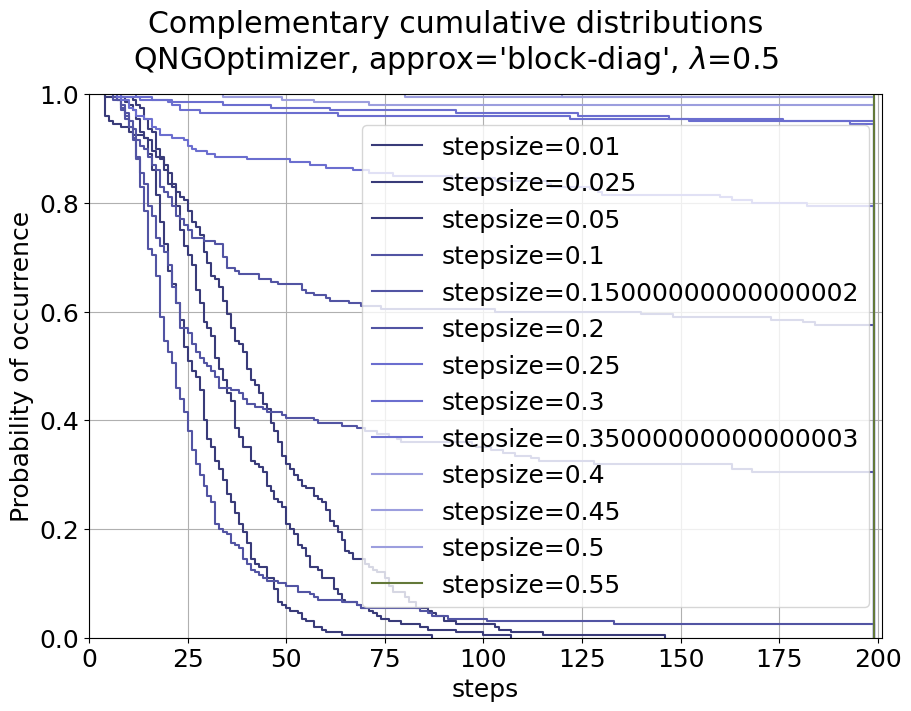

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [18]:
import matplotlib as mpl

cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 60))

for i,session in enumerate(sessions):
    fig = plt.figure(figsize=(9, 7), layout="compressed")
    axs = fig.subplots(1, 1, sharex=True, sharey=True)
    
    # Cumulative distributions.
    
    for j,stepsize in enumerate(session["stepsizes"]):
        axs.ecdf(sessions_steps[i][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )
        
    # Label the figure.
    title = "Complementary cumulative distributions\n" + session["optimizer"].__class__.__name__
    if(len(session["params_name"]) > 0):
        title += ", " + session["params_name"]
    
    fig.suptitle(title)
    
    axs.grid(True)
    axs.legend()
    axs.set_xlabel("steps")
    axs.set_ylabel("Probability of occurrence")
    axs.label_outer()
    axs.set_xlim(0.0, 201)
    plt.show()
    fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_steps.png",format='png',dpi=300)
    fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_steps.pdf",format='pdf',dpi=300)
    fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ccdf_steps.eps",format='eps',dpi=300)

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 11

'''

fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(2, 2, sharex=True, sharey=True)

# Cumulative distributions.
cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 20))

for j,stepsize in enumerate(sessions[0]["stepsizes"]):
    axs[0][0].ecdf(sessions_quality[0][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )
for j,stepsize in enumerate(sessions[1]["stepsizes"]):
    axs[0][1].ecdf(sessions_quality[1][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )
for j,stepsize in enumerate(sessions[2]["stepsizes"]):
    axs[1][1].ecdf(sessions_quality[2][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )
for j,stepsize in enumerate(sessions[3]["stepsizes"]):
    axs[1][0].ecdf(sessions_quality[3][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )

session_id = [0,1,3,2]
axs[0][0].text(0.07,0.07,"(a)",fontsize=16)
axs[0][1].text(0.07,0.07,"(b)",fontsize=16)
axs[1][0].text(0.07,0.07,"(c)",fontsize=16)
axs[1][1].text(0.07,0.07,"(d)",fontsize=16)
fig.suptitle("Complementary cumulative distributions")
for i in range(2):
    for j in range(2):
        axs[j][i].grid(True)
        axs[j][i].set_xlabel("quality ratio")
        axs[j][i].set_ylabel("Probability of occurrence")
        axs[j][i].label_outer()
        axs[j][i].set_xlim(0.0, 1)
        axs[j][i].legend(loc="upper right",fontsize=8)
        session = sessions[session_id[i*2+j]]
        title = session["optimizer"].__class__.__name__
        if(len(session["params_name"]) > 0):
            title += "\n" + session["params_name"]
        axs[i][j].set_title(title)
        
plt.show()
fig.savefig(prefix_name + "quality_ccdf.png",format='png',dpi=300)
fig.savefig(prefix_name + "quality_ccdf.pdf",format='pdf',dpi=300)
fig.savefig(prefix_name + "quality_ccdf.eps",format='eps',dpi=300)
'''

In [ ]:
'''
import matplotlib as mpl
mpl.rcParams['font.size'] = 11

fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(2, 2, sharex=True, sharey=True)

# Cumulative distributions.
cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 20))

for j,stepsize in enumerate(sessions[0]["stepsizes"]):
    axs[0][0].ecdf(sessions_steps[0][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )
for j,stepsize in enumerate(sessions[1]["stepsizes"]):
    axs[0][1].ecdf(sessions_steps[1][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )
for j,stepsize in enumerate(sessions[2]["stepsizes"]):
    axs[1][1].ecdf(sessions_steps[2][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )
for j,stepsize in enumerate(sessions[3]["stepsizes"]):
    axs[1][0].ecdf(sessions_steps[3][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )

session_id = [0,1,3,2]

axs[0][0].text(5,0.07,"(a)",fontsize=16)
axs[0][1].text(5,0.07,"(b)",fontsize=16)
axs[1][0].text(5,0.07,"(c)",fontsize=16)
axs[1][1].text(5,0.07,"(d)",fontsize=16)
fig.suptitle("Complementary cumulative distributions")
for i in range(2):
    for j in range(2):
        axs[j][i].grid(True)
        axs[j][i].set_xlabel("steps")
        axs[j][i].set_ylabel("Probability of occurrence")
        axs[j][i].label_outer()
        axs[j][i].set_xlim(0.0, 201)
        axs[j][i].legend(loc="upper right",fontsize=8)
        session = sessions[session_id[i*2+j]]
        title = session["optimizer"].__class__.__name__
        if(len(session["params_name"]) > 0):
            title += "\n" + session["params_name"]
        axs[i][j].set_title(title)
        
plt.show()
fig.savefig(prefix_name + "steps_ccdf.png",format='png',dpi=300)
fig.savefig(prefix_name + "steps_ccdf.pdf",format='pdf',dpi=300)
fig.savefig(prefix_name + "steps_ccdf.eps",format='eps',dpi=300)
'''

In [ ]:
#!pip install torch

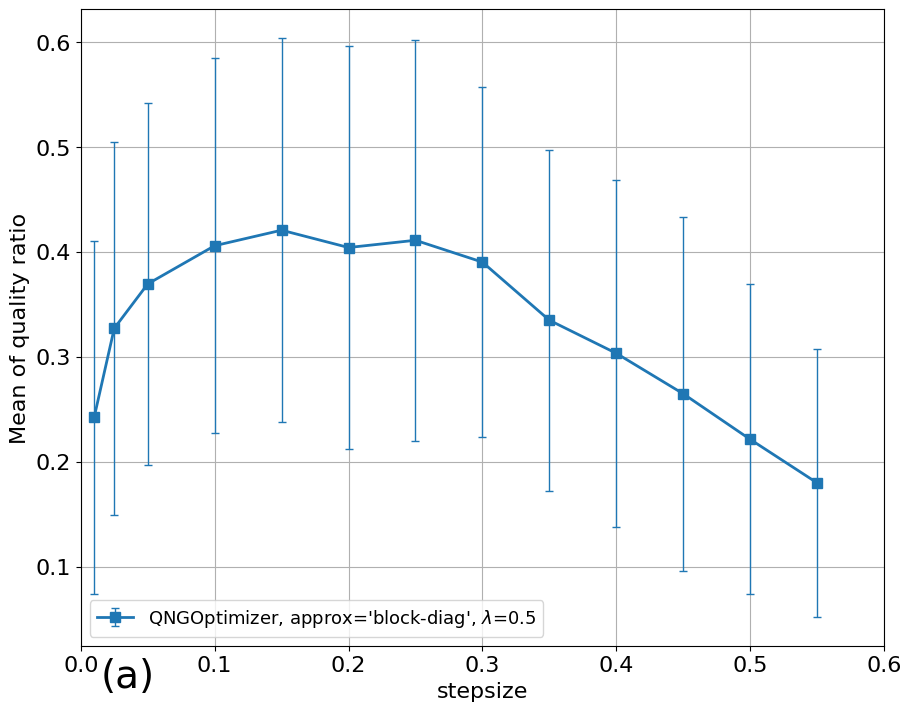

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [20]:
import matplotlib as mpl
import statistics
import math
import torch

mpl.rcParams['font.size'] = 16

cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 60))
fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(1, 1, sharex=True, sharey=True)
axs.text(0.015,-0.015,"(a)",fontsize=28)
format_plot = ["s-","o-","v-","^-"]
for i,session in enumerate(sessions):
    ave_session = []
    stdev_session = []
    for j,stepsize in enumerate(session["stepsizes"]):
        quality = []
        for k in range(init_count):
            quality.append(float(sessions_quality[i][j][k]))
        ave_val = statistics.mean(quality)
        stdev_val = statistics.stdev(quality)
        ave_session.append(ave_val)
        if(stdev_val == 'NaN'):
            stdev_val = 0
        stdev_session.append(stdev_val)
    label = session["optimizer"].__class__.__name__
    if(len(session["params_name"]) > 0):
        label += ", " + session["params_name"]
    axs.errorbar(session["stepsizes"],ave_session,yerr=stdev_session,elinewidth=1,label=label,capsize=3,fmt=format_plot[i],ms=7,lw=2)
  
    axs.grid(True)
    axs.legend(fontsize=13)
    axs.set_xlabel("stepsize")
    axs.set_ylabel("Mean of quality ratio")
    #axs.label_outer()
    axs.set_xlim(0.0, 0.6)
plt.show()
fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_quality.png",format='png',dpi=300)
fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_quality.pdf",format='pdf',dpi=300)
fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_quality.eps",format='eps',dpi=300)

In [ ]:
import matplotlib as mpl
import statistics
import math
import torch

cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 60))
fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(1, 1, sharex=True, sharey=True)
axs.text(0.015,-8.0,"(b)",fontsize=28)
format_plot = ["s-","o-","v-","^-"]
for i,session in enumerate(sessions):
    ave_session = []
    stdev_session = []
    for j,stepsize in enumerate(session["stepsizes"]):
        arr_steps = []
        for k in range(init_count):
            arr_steps.append(float(sessions_steps[i][j][k]))
        ave_val = statistics.mean(arr_steps)
        stdev_val = statistics.stdev(arr_steps)
        ave_session.append(ave_val)
        if(stdev_val == 'NaN'):
            stdev_val = 0
        stdev_session.append(stdev_val)
    label = session["optimizer"].__class__.__name__
    if(len(session["params_name"]) > 0):
        label += ", " + session["params_name"]
    axs.errorbar(session["stepsizes"],ave_session,yerr=stdev_session,elinewidth=1,label=label,capsize=3,fmt=format_plot[i],ms=7,lw=2)
  
    axs.grid(True)
    axs.legend(fontsize=13)
    axs.set_xlabel("stepsize")
    axs.set_ylabel("Mean of steps")
    #axs.label_outer()
    axs.set_xlim(0.0, 0.26)
plt.show()
fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_steps.png",format='png',dpi=300)
fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_steps.pdf",format='pdf',dpi=300)
fig.savefig(prefix_name + session["optimizer"].__class__.__name__+"_ave_steps.eps",format='eps',dpi=300)

In [ ]:
from datetime import date
import ipynbname


start_name = ipynbname.name() + "_"
tail_name = "_depth=" + str(depth)+"_" + str(date.today()) + ".dat"
with open(start_name + "quality" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                line += str(sessions_quality[i][k][j]) + " "
        print(j,line,file=file)

with open(start_name + "costs" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                line += str(sessions_costs[i][k][j]) + " "
        print(j,line,file=file)

with open(start_name + "steps" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                line += str(sessions_steps[i][k][j]) + " "
        print(j,line,file=file)

with open(start_name + "asym" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                line += str(sessions_asym[i][k][j]) + " "
        print(j,line,file=file)

with open(start_name + "params" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                line += str(sessions_params[i][k][j][0]) + " " + str(sessions_params[i][k][j][1]) + " "
        print(j,line,file=file)
